In [3]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import pandas as pd
from collections import Counter

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [25]:
nba_players = pd.read_csv('./NBA_clean.csv', index_col=0)
nba_players = nba_players.sample(frac=1) #shuffle 100% of rows
nba_players = nba_players.reset_index(drop=True)

Counter(nba_players.loc[:,'Pos'])
#Class distribution is roughly balanced

Counter({'C': 72, 'PG': 84, 'SG': 100, 'PF': 90, 'SF': 76})

In [6]:
def normalize(nba_players):
    nbamean = np.mean(nba_players.loc[:, nba_players.columns != 'Pos'], axis = 0)
    nba_players = nba_players - nbamean
    nbastd = np.std(nba_players.loc[:, nba_players.columns != 'Pos'], axis = 0)
    nba_players = nba_players / nbastd
    return nba_players, nbamean, nbastd

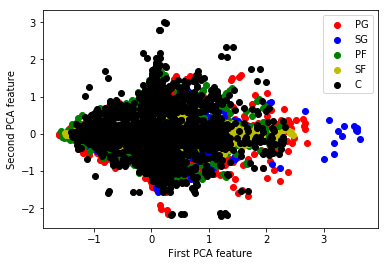

In [7]:
normalized_data,_,_ = normalize(nba_players.loc[:, nba_players.columns != 'Pos'])

f = normalized_data.loc[:, normalized_data.columns != 'Pos']
U,S,Vh = np.linalg.svd(f.T, full_matrices=True)

#Find and plot top two principal features
Uhat = U[:,0][:,None]
PC1 = np.matmul(Uhat, np.matmul(Uhat.T, f.T)).T
Uhat = U[:,1][:,None]
PC2 = np.matmul(Uhat, np.matmul(Uhat.T, f.T)).T

idx1 = np.where(nba_players['Pos'] == 'PG')[0]
idx2 = np.where(nba_players['Pos'] == 'SG')[0]
idx3 = np.where(nba_players['Pos'] == 'PF')[0]
idx4 = np.where(nba_players['Pos'] == 'SF')[0]
idx5 = np.where(nba_players['Pos'] == 'C')[0]

plt.scatter(PC1[idx1], PC2[idx1], c='r')
plt.scatter(PC1[idx2], PC2[idx2], c='b')
plt.scatter(PC1[idx3], PC2[idx3], c='g')
plt.scatter(PC1[idx4], PC2[idx4], c='y')
plt.scatter(PC1[idx5], PC2[idx5], c='k')
plt.legend(['PG', 'SG', 'PF', 'SF', 'C'])
plt.xlabel('First PCA feature')
plt.ylabel('Second PCA feature')
plt.show()


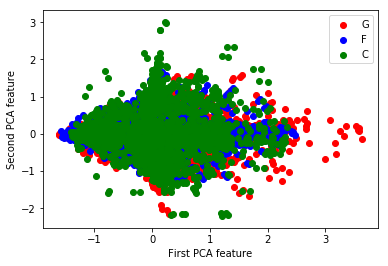

In [8]:
labels = nba_players.loc[:, 'Pos']
genpos = []
#Relabel classes to center, guard, and forward
for a in labels:
    genpos.append(a[-1])
generalized_nba_players = nba_players.loc[:, nba_players.columns != 'Pos']
generalized_nba_players['Pos'] = genpos

normalized_data,_,_ = normalize(generalized_nba_players.loc[:, generalized_nba_players.columns != 'Pos'])

f = normalized_data.loc[:, normalized_data.columns != 'Pos']
U,S,Vh = np.linalg.svd(f.T, full_matrices=True)

#Find and plot top two principal features
Uhat = U[:,0][:,None]
PC1 = np.matmul(Uhat, np.matmul(Uhat.T, f.T)).T
Uhat = U[:,1][:,None]
PC2 = np.matmul(Uhat, np.matmul(Uhat.T, f.T)).T

idx1 = np.where(generalized_nba_players['Pos'] == 'G')[0]
idx2 = np.where(generalized_nba_players['Pos'] == 'F')[0]
idx3 = np.where(generalized_nba_players['Pos'] == 'C')[0]

plt.scatter(PC1[idx1], PC2[idx1], c='r')
plt.scatter(PC1[idx2], PC2[idx2], c='b')
plt.scatter(PC1[idx3], PC2[idx3], c='g')
plt.legend(['G', 'F', 'C'])
plt.xlabel('First PCA feature')
plt.ylabel('Second PCA feature')
plt.show()

In [9]:
#Set aside some data for validation later
validation_data  = nba_players.loc[360:421, nba_players.columns != 'Pos']
validation_labels = nba_players.loc[360:421, 'Pos']

#Do the same for the combined class dataset
gen_validation_data  = generalized_nba_players.loc[360:421, generalized_nba_players.columns != 'Pos']
gen_validation_labels = generalized_nba_players.loc[360:421, 'Pos']

In [26]:
#Define k-fold splits
splits = [0, 60 - 1, 120 - 1, 180 - 1, 240 - 1, 300 - 1, 360 - 1]

def cross_validation(nba_players, KNN, use_pca=True, n=5):
    p = []
    pos_labels=["PG", "SG", "C", "PF", "SF"]
    if n == 3:
        pos_labels = ["G", "C", "F"]
    confusion_mat = np.zeros((n, n))
    for i in range(len(splits) - 1):
        #Build training and testing data from the splits
        s1 = training_data = nba_players.loc[0:splits[i]-1, nba_players.columns != 'Pos']
        s2 = training_data = nba_players.loc[splits[i+1]+1:359, nba_players.columns != 'Pos']
        l1 = training_data = nba_players.loc[0:splits[i]-1, 'Pos']
        l2 = training_data = nba_players.loc[splits[i+1]+1:359,  'Pos']
        training_data = pd.concat([s1, s2])
        training_labels = pd.concat([l1, l2])
        testing_data = nba_players.loc[splits[i]:splits[i+1], nba_players.columns != 'Pos']
        testing_labels = nba_players.loc[splits[i]:splits[i+1], 'Pos']
        training_data = training_data.reset_index(drop=True)
        testing_data = testing_data.reset_index(drop=True)

        if use_pca:
            training_data, tmean, tstd = normalize(training_data)
            U,S,Vh = np.linalg.svd(training_data.T, full_matrices=True)
            totalerr = np.linalg.norm(S,2)**2
            currenterr = 0
            idx = 0
            while currenterr < 0.95*totalerr:
                currenterr+=S[idx]**2
                idx+=1
            Uhat = U[:,:idx]
            training_data = np.matmul(Uhat, np.matmul(Uhat.T, training_data.T)).T
            testing_data = (testing_data - tmean)/tstd
            testing_data = np.matmul(Uhat, np.matmul(Uhat.T, testing_data.T)).T

        KNN.fit(training_data, training_labels)
        acc = KNN.score(testing_data, testing_labels)
        pred = KNN.predict(testing_data)
        conf_mat = confusion_matrix(testing_labels, pred, labels = pos_labels)
        p.append(acc)
        confusion_mat += conf_mat
        #print('Fold', i)
        #print(conf_mat)
    confusion_mat /= 6
    print("Final confusion matrix:")
    print(confusion_mat)
    return np.mean(p)

In [28]:
klist = [4,5,6,7,8,9,10,11,12]
perf = []
for k in klist:
    KNN = KNeighborsClassifier(n_neighbors=k)
    perf.append(cross_validation(nba_players, KNN, n=5))
print('Best k to choose: ', klist[np.argmin(perf)])
print('Mean accuracy: ', np.mean(perf))

Final confusion matrix:
[[9.5        2.16666667 0.         0.         0.16666667]
 [3.33333333 8.         0.16666667 0.16666667 2.83333333]
 [0.         0.         7.5        2.66666667 0.66666667]
 [0.16666667 0.33333333 3.33333333 7.33333333 1.66666667]
 [0.16666667 1.33333333 0.33333333 2.         7.        ]]
Final confusion matrix:
[[8.83333333 2.5        0.         0.         0.5       ]
 [3.         8.16666667 0.         0.83333333 2.5       ]
 [0.         0.         6.33333333 3.83333333 0.66666667]
 [0.16666667 0.         3.16666667 7.5        2.        ]
 [0.16666667 1.83333333 0.33333333 2.16666667 6.33333333]]
Final confusion matrix:
[[9.33333333 2.33333333 0.         0.         0.16666667]
 [2.66666667 8.83333333 0.16666667 0.66666667 2.16666667]
 [0.         0.16666667 7.5        2.5        0.66666667]
 [0.         0.16666667 3.33333333 7.5        1.83333333]
 [0.16666667 2.         0.16666667 1.33333333 7.16666667]]
Final confusion matrix:
[[9.33333333 2.16666667 0.     

In [32]:
#validate
def validateKNN(nba_players, validation_data, validation_labels, classifier, use_pca=True, n=3):
    pos_labels = ["G", "C", "F"]
    if n == 5:
        pos_labels=["PG", "SG", "C", "PF", "SF"]
    training_data = nba_players.loc[0:359, nba_players.columns != 'Pos']
    training_labels = nba_players.loc[0:359, 'Pos']
    training_data = training_data.reset_index(drop=True)
    
    if use_pca:
        training_data, tmean, tstd = normalize(training_data)
        U,S,Vh = np.linalg.svd(training_data.T, full_matrices=True)
        totalerr = np.linalg.norm(S,2)**2
        currenterr = 0
        idx = 0
        while currenterr < 0.95*totalerr:
            currenterr+=S[idx]**2
            idx+=1
        Uhat = U[:,:idx]
        training_data = np.matmul(Uhat, np.matmul(Uhat.T, training_data.T)).T

    classifier.fit(training_data, training_labels)
    if use_pca:
        validation_data = (validation_data - tmean)/tstd
        validation_data = np.matmul(Uhat, np.matmul(Uhat.T, validation_data.T)).T
    acc = classifier.score(validation_data, validation_labels)
    pred = classifier.predict(validation_data)
    print('Confusion matrix:')
    print(confusion_matrix(validation_labels, pred, labels = pos_labels))
    print("Accuracy:")
    print(acc)
    return acc

In [35]:
validateKNN(nba_players, validation_data, validation_labels, KNeighborsClassifier(n_neighbors=klist[np.argmin(perf)]), n=5)

Confusion matrix:
[[11  2  0  0  0]
 [ 2  5  0  0  4]
 [ 0  0  6  2  1]
 [ 0  1  5 10  0]
 [ 0  2  1  1  9]]
Accuracy:
0.6612903225806451


0.6612903225806451

In [29]:
klist = [4,5,6,7,8,9,10,11,12]
perf = []
for k in klist:
    KNN = KNeighborsClassifier(n_neighbors=k)
    perf.append(cross_validation(generalized_nba_players, KNN))
print('Best k to choose: ', klist[np.argmin(perf)])
print('Mean accuracy: ', np.mean(perf))

Final confusion matrix:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         7.83333333 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Final confusion matrix:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         6.66666667 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Final confusion matrix:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         7.16666667 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
Final confusion matrix:
[[0.         0.         0.     

In [36]:
validateKNN(generalized_nba_players, gen_validation_data, gen_validation_labels, KNeighborsClassifier(n_neighbors=klist[np.argmin(perf)]))

Confusion matrix:
[[21  0  3]
 [ 0  6  3]
 [ 3  6 20]]
Accuracy:
0.7580645161290323


0.7580645161290323

# Decision Tree Classifier

In [38]:
depths = [1,2, 3, 4, 5]
samples = [0.02, 0.05, 0.1, 0.2, 1]
#parameter variations for cross validation
perf = []
best = 0
opt = (0, 0)
for m in depths:
    for s in samples:
        DT = DecisionTreeClassifier(max_depth=m, min_samples_leaf=s)
        perf.append(cross_validation(generalized_nba_players, DT, use_pca=True,n=3))
        if perf[-1] > best:
            best = perf[-1]
            opt = (m, s)
        print('Performance was {:.3f} with depth={} and samples={}'.format(perf[-1], m, s))
    print()
print('Optimal performance was {:.3f} with depth={} and samples={}'.format(best, *opt))

Final confusion matrix:
[[24.16666667  0.          3.        ]
 [ 0.          0.         10.5       ]
 [ 1.16666667  0.         22.        ]]
Performance was 0.759 with depth=1 and samples=0.02
Final confusion matrix:
[[24.16666667  0.          3.        ]
 [ 0.          0.         10.5       ]
 [ 1.16666667  0.         22.        ]]
Performance was 0.759 with depth=1 and samples=0.05
Final confusion matrix:
[[24.16666667  0.          3.        ]
 [ 0.          0.         10.5       ]
 [ 1.16666667  0.         22.        ]]
Performance was 0.759 with depth=1 and samples=0.1
Final confusion matrix:
[[24.16666667  0.          3.        ]
 [ 0.          0.         10.5       ]
 [ 1.16666667  0.         22.        ]]
Performance was 0.759 with depth=1 and samples=0.2
Final confusion matrix:
[[24.16666667  0.          3.        ]
 [ 0.          0.         10.5       ]
 [ 1.16666667  0.         22.        ]]
Performance was 0.759 with depth=1 and samples=1

Final confusion matrix:
[[23.83333

In [39]:
optTree = DecisionTreeClassifier(max_depth=opt[0], min_samples_leaf=opt[1])
optPerf = validateKNN(generalized_nba_players, gen_validation_data, gen_validation_labels, optTree, use_pca=False)

print('The performance on the validation data is {:.3f}'.format(optPerf))


Confusion matrix:
[[24  0  0]
 [ 0  7  2]
 [ 2  5 22]]
Accuracy:
0.8548387096774194
The performance on the validation data is 0.855


In [40]:
data = nba_players.loc[:, nba_players.columns != 'Pos']
label_map = {'PG':0, 'SG':1, 'PF':2, 'SF':3, 'C':4}
labels = np.array([label_map[pos] for pos in nba_players['Pos']])



for run_pca in (True, False):
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    accuracy = 0
    for i, (train_indices, test_indices) in enumerate(skf.split(data, labels)):

        train_data = nba_players.loc[train_indices, nba_players.columns != 'Pos']
        test_data = nba_players.loc[test_indices, nba_players.columns != 'Pos']
        
        if run_pca:
            train_data, tmean, tstd = normalize(train_data)
            U,S,Vh = np.linalg.svd(train_data.T, full_matrices=True)
            totalerr = np.linalg.norm(S, 2)**2
            currenterr = 0
            idx = 0
            while currenterr < 0.95*totalerr:
                currenterr+=S[idx]**2
                idx+=1
            Uhat = U[:,:idx]
            train_data = np.matmul(Uhat, np.matmul(Uhat.T, train_data.T)).T
            test_data = (test_data - tmean)/tstd
            test_data = np.matmul(Uhat, np.matmul(Uhat.T, test_data.T)).T

        qda = QuadraticDiscriminantAnalysis(store_covariance=True)
        qda.fit(train_data, labels[train_indices])
        acc = qda.score(test_data, labels[test_indices])
        print('Fold', i, acc)
        accuracy += acc
    accuracy /= 5
    print('Accuracy ' + ('with PCA ' if run_pca else '') + str(accuracy))
    print()

Fold 0 0.5465116279069767
Fold 1 0.5647058823529412
Fold 2 0.6428571428571429
Fold 3 0.6190476190476191
Fold 4 0.6144578313253012
Accuracy with PCA 0.5975160206979961

Fold 0 0.6511627906976745
Fold 1 0.7294117647058823
Fold 2 0.6309523809523809
Fold 3 0.6547619047619048
Fold 4 0.6144578313253012
Accuracy 0.6561493344886287



C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
